<a href="https://colab.research.google.com/github/tobp03/project-RA/blob/main/Lending%20Risk%20Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lending Risk Assessment**

In this notebook, the steps are divided as:
1. Payment History data cleaning and analysis
2. Previous Applications data cleaning and analysis
3. Customer segmentation with K-Means
4. Training data cleaning, analysis, feature engineering, and processing.
5. Merge feature columns with label.
6. Modeling

**Import Dataset and Python libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("/content/drive/MyDrive/Dataset (CSV)/train.csv", sep =",")
df = pd.read_csv("/content/drive/MyDrive/Dataset (CSV)/payment_history.csv", sep =",")

# **Payment History data cleaning and analysis**

Dataset have a size of (2871633, 7). Found some abnormalities:
* AMS_INST has observations with a value of 0. Which means theres no bill on certain installment. Looks like it is not possible
* AMT_PAY also has observations with a value of 0.
Observing AMS_INST values with value of 0, found that payments are still being made. Lets say that every AMT_INST with value of 0 are payed fully.

However for AMT_PAY, a installment could be paid in more than once. Need to aggregate AMT_PAY.



In [4]:
df.shape

(2872306, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872306 entries, 0 to 2872305
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   SK_ID_PREV   int64  
 1   U_ID         int64  
 2   INST_NUMBER  int64  
 3   INST_DAYS    float64
 4   PAY_DAYS     float64
 5   AMT_INST     float64
 6   AMT_PAY      float64
dtypes: float64(4), int64(3)
memory usage: 153.4 MB


In [6]:
df.describe()

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
count,2.872306e+06,2.872306e+06,2.872306e+06,2.872306e+06,2.871633e+06,2.872306e+06,2.871633e+06
mean,1.902798e+06,2.785208e+05,1.865887e+01,-1.039830e+03,-1.048684e+03,1.692881e+04,1.708792e+04
std,5.358735e+05,1.026814e+05,2.635638e+01,7.995411e+02,7.991129e+02,5.010468e+04,5.422172e+04
min,1.000020e+06,1.000090e+05,1.000000e+00,-2.922000e+03,-3.129000e+03,0.000000e+00,0.000000e+00
25%,1.435627e+06,1.893100e+05,4.000000e+00,-1.651000e+03,-1.659000e+03,4.199850e+03,3.389490e+03
50%,1.894453e+06,2.786890e+05,8.000000e+00,-8.170000e+02,-8.260000e+02,8.787330e+03,8.095050e+03
75%,2.368624e+06,3.675770e+05,1.900000e+01,-3.580000e+02,-3.670000e+02,1.661709e+04,1.597320e+04
max,2.843498e+06,4.562550e+05,2.250000e+02,-2.000000e+00,-2.000000e+00,3.371884e+06,3.371884e+06


In [7]:
df[df['AMT_PAY']==0].sort_values(by='INST_NUMBER')

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
868278,2783804,242187,2,-2290.0,-2315.0,2250.0,0.0
953489,1761003,268744,2,-2220.0,-2250.0,6750.0,0.0
2310432,2652019,445660,2,-2196.0,-2204.0,9000.0,0.0
2027021,1974859,449538,2,-2480.0,-2486.0,6750.0,0.0
2304752,1798118,455496,2,-2193.0,-2217.0,9000.0,0.0
...,...,...,...,...,...,...,...
1727448,2246009,321055,43,-2312.0,-2337.0,4050.0,0.0
1442265,2397304,304240,44,-2291.0,-2321.0,6750.0,0.0
618314,2018068,140249,45,-2269.0,-2297.0,6750.0,0.0
529733,2018068,140249,47,-2208.0,-2236.0,6750.0,0.0


In [8]:
df[df['SK_ID_PREV']==1410565].sort_values(by='INST_NUMBER')

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
3,1410565,197687,1,-1037.0,-1048.0,12514.05,12510.45
210513,1410565,197687,1,-1037.0,-1029.0,12514.05,3.60
518442,1410565,197687,2,-1007.0,-1008.0,12514.05,12514.05
515237,1410565,197687,3,-977.0,-980.0,12514.05,12514.05
150298,1410565,197687,4,-947.0,-948.0,12514.05,12514.05
236477,1410565,197687,5,-917.0,-920.0,12514.05,12514.05
503180,1410565,197687,6,-887.0,-920.0,12450.51,12450.51


{'whiskers': [<matplotlib.lines.Line2D at 0x79e0be378130>,
 'caps': [<matplotlib.lines.Line2D at 0x79e0be378670>,
 'boxes': [<matplotlib.lines.Line2D at 0x79e0be32bac0>,
 'medians': [<matplotlib.lines.Line2D at 0x79e0be378bb0>,
 'fliers': [<matplotlib.lines.Line2D at 0x79e0be378e50>,
 'means': []}

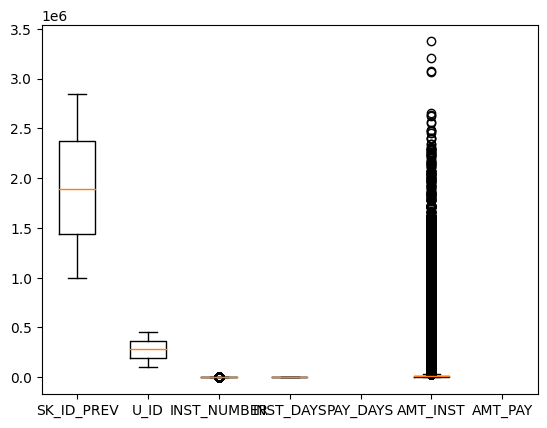

In [9]:
plt.boxplot(df.values, labels=df.columns)

### **Observations with missing values**

Theres 673 obsevations with NAs on PAY_DAYS dan AMT_PAY. However, all missing values seemed to be on the same observations. Because the amount isnt significant, observation with missing values are dropped.

In [10]:
df.isna().sum()

SK_ID_PREV       0
U_ID             0
INST_NUMBER      0
INST_DAYS        0
PAY_DAYS       673
AMT_INST         0
AMT_PAY        673
dtype: int64

In [11]:
df[df['PAY_DAYS'].isna()]

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
645595,1265332,167942,5,-14.0,NaN,11650.500,NaN
645596,2776343,151961,31,-2.0,NaN,15097.275,NaN
645597,2312379,107766,46,-1464.0,NaN,67.500,NaN
645598,1319969,133112,22,-58.0,NaN,33089.310,NaN
645599,1153254,120931,26,-1440.0,NaN,67.500,NaN
...,...,...,...,...,...,...,...
2872080,1666631,429716,38,-1797.0,NaN,67.500,NaN
2872081,1280188,435393,35,-1678.0,NaN,67.500,NaN
2872192,2682640,418699,1,-24.0,NaN,42419.205,NaN
2872193,1766391,413446,45,-1668.0,NaN,67.500,NaN


In [12]:
df = df.dropna()

### **Data preprocessing**
Aggregate are done with grouping on ['SK_ID_PREV','U_ID', 'INST_NUMBER']. The goal of this aggregation is for adding up together a single installment payment that is made more than once.

In [13]:
df2 = df.groupby(['SK_ID_PREV','U_ID', 'INST_NUMBER']).agg({'INST_DAYS': 'last','PAY_DAYS': 'last','AMT_INST': 'first', 'AMT_PAY': 'sum'}).reset_index().copy()
#df2 = df.groupby(['SK_ID_PREV', 'INST_NUMBER']).agg({'U_ID': 'first','INST_DAYS': 'first','PAY_DAYS': 'first','AMT_INST': 'first', 'AMT_PAY': 'sum'}).copy()

In [14]:
#Rounding
df2['AMT_INST']=df2['AMT_INST'].round(2)
df2['AMT_PAY']=df2['AMT_PAY'].round(2)

Feature engineer a new variable called unpaid debt and days late.  

In [15]:
df2['unpaid_debt'] = df2['AMT_INST'] - df2['AMT_PAY']
df2['unpaid_debt'] = df2['unpaid_debt'].apply(lambda x: max(0, x))
#df2['FULLY_PAYED'] = np.where(df2['AMT_INST']==df2['AMT_PAY'],1,0) #Nilai 1 jika udah terbayar sepenuhnya, 0 jika tidak

In [16]:
df2[df2['unpaid_debt']>0]

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,unpaid_debt
1042,1000506,326447,11,-1657.0,-1687.0,9665.33,9665.32,0.01
1464,1000732,166562,7,-822.0,-819.0,16330.82,16330.81,0.01
1468,1000732,166562,11,-702.0,-697.0,16330.82,16330.81,0.01
1929,1000859,314738,36,-1449.0,-1476.0,67.50,19.80,47.70
2333,1000954,378082,3,-549.0,-578.0,51849.32,51849.31,0.01
...,...,...,...,...,...,...,...,...
2711547,2842285,112030,3,-469.0,-503.0,27926.60,27926.59,0.01
2711811,2842431,431245,1,-1088.0,-1097.0,18222.62,18222.61,0.01
2712399,2842725,319595,7,-1692.0,-1670.0,2588.18,2588.17,0.01
2712654,2842861,370469,6,-703.0,-701.0,26704.76,26704.75,0.01


In [17]:
df2

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,unpaid_debt
0,1000020,299072,1,-1986.0,-2000.0,18393.16,18393.16,0.0
1,1000020,299072,2,-1956.0,-1973.0,18393.16,18393.16,0.0
2,1000020,299072,3,-1926.0,-1941.0,18393.16,18393.16,0.0
3,1000020,299072,4,-1896.0,-1912.0,18393.16,18393.16,0.0
4,1000020,299072,5,-1866.0,-1882.0,18393.16,18393.16,0.0
...,...,...,...,...,...,...,...,...
2714154,2843498,393881,2,-1412.0,-1424.0,16191.99,16191.99,0.0
2714155,2843498,393881,3,-1382.0,-1395.0,16191.99,16191.99,0.0
2714156,2843498,393881,4,-1352.0,-1367.0,16191.99,16191.99,0.0
2714157,2843498,393881,5,-1322.0,-1336.0,16191.99,16191.99,0.0


In [18]:
df2['days_late'] = df2['PAY_DAYS'] - df2['INST_DAYS']
df2['days_late'] = df2['days_late'].apply(lambda x: max(0, x))

In [19]:
df2[df2['SK_ID_PREV']==1410565]

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,unpaid_debt,days_late
640765,1410565,197687,1,-1037.0,-1029.0,12514.05,12514.05,0.0,8.0
640766,1410565,197687,2,-1007.0,-1008.0,12514.05,12514.05,0.0,0.0
640767,1410565,197687,3,-977.0,-980.0,12514.05,12514.05,0.0,0.0
640768,1410565,197687,4,-947.0,-948.0,12514.05,12514.05,0.0,0.0
640769,1410565,197687,5,-917.0,-920.0,12514.05,12514.05,0.0,0.0
640770,1410565,197687,6,-887.0,-920.0,12450.51,12450.51,0.0,0.0


Do another aggregation by grouping ['SK_ID_PREV','U_ID', 'INST_NUMBER'], the goal is to find out the total amount of debt and days late for each lending application.

In [20]:
df3 = df2.groupby(['SK_ID_PREV','U_ID']).agg({'INST_NUMBER': 'count','unpaid_debt': 'sum','days_late': 'sum'}).reset_index().copy()
df3 = df3.rename(columns={'INST_NUMBER': 'num_inst'})

In [21]:
df3.shape

(211711, 5)

In [22]:
df3.nunique()

SK_ID_PREV     211711
U_ID            72299
num_inst          198
unpaid_debt       699
days_late         852
dtype: int64

In [23]:
df3.head()

,SK_ID_PREV,U_ID,num_inst,unpaid_debt,days_late
0,1000020,299072,12,0.0,0.0
1,1000023,350748,4,0.0,0.0
2,1000024,448518,12,0.0,0.0
3,1000026,227096,4,0.0,0.0
4,1000027,277601,6,0.0,0.0


# **Previous Applications data cleaning and analysis**

Since all previous payment ID on payment history is only shown at previous applications dataset with "approved" on contract status, previous applications dataset will be filtered with "approved".

In [24]:
df_loan = pd.read_csv("/content/drive/MyDrive/Dataset (CSV)/previous_applications.csv", sep =",")

In [25]:
df_loan

,SK_ID_PREV,U_ID,CONTRACT_TYPE,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_DAYS,APPLY_HOUR,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0
1,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0
2,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Approved,-684,18.0,low_normal,365243.0,-654.0,-137.0,1.0
3,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Canceled,-14,NaN,NA1,NaN,NaN,NaN,NaN
4,1715995,447712,Cash loans,11368.620,270000.0,335754.0,NaN,270000.0,FRIDAY,7,Approved,-735,54.0,low_normal,365243.0,-705.0,-334.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350707,1379569,309506,Cash loans,33389.100,1035000.0,1035000.0,NaN,1035000.0,THURSDAY,10,Refused,-156,60.0,low_normal,NaN,NaN,NaN,NaN
350708,1252861,363895,Cash loans,56754.000,1350000.0,1350000.0,NaN,1350000.0,THURSDAY,16,Refused,-847,48.0,middle,NaN,NaN,NaN,NaN
350709,1379406,302265,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,13,Canceled,-502,NaN,NA1,NaN,NaN,NaN,NaN
350710,2698899,161204,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,13,Canceled,-359,NaN,NA1,NaN,NaN,NaN,NaN


In [26]:
df_loan = df_loan[df_loan['CONTRACT_STATUS']=='Approved']

Based on this dataset, we made some assumptions on which variables is important for customer segmentation based on risks.
* Limit given to the customer
* Interest given to the customer is given by YIELD_GROUP variable. Previous interest given to the applicants will be taken in account as risk, as the BNPL company might have their own calculation not given in the dataset.
* Insured application is given by NFLAG_INSURED_ON_APPROVAL variable. Insured applicant reduce the risk held by the BNPL company as it increase the chances of them getting their money back.



## **Eksplorasi**

Found 8280 empty cells on NFLAG_INSURED_ON_APPROVAL. The variable APPLICATION dan APPROVED_CREDIT has some observation values with 0.

In [27]:
df_loan.describe()

,SK_ID_PREV,U_ID,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_HOUR,DAYS_DECISION,TERM_PAYMENT,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,2.196870e+05,219687.000000,219685.000000,2.196870e+05,2.196870e+05,1.408600e+05,2.104650e+05,219687.000000,219687.000000,219685.000000,211407.000000,211407.000000,211407.000000,211407.000000
mean,1.904350e+06,278373.284286,14585.846247,1.794100e+05,2.014853e+05,6.832135e+03,1.872712e+05,12.602648,-1097.152235,14.171819,342238.632122,13228.355887,82378.742109,0.331980
std,5.353069e+05,102659.397670,13626.136079,2.536923e+05,2.755490e+05,1.853554e+04,2.563351e+05,3.319055,792.382703,12.014098,88866.480608,71030.663471,153553.036032,0.470925
min,1.000020e+06,100009.000000,0.000000,0.000000e+00,0.000000e+00,-4.500000e-01,0.000000e+00,0.000000,-2922.000000,0.000000,-2922.000000,-2892.000000,-2845.000000,0.000000
25%,1.435808e+06,189444.000000,5883.345000,4.500000e+04,4.743450e+04,0.000000e+00,4.594050e+04,10.000000,-1638.000000,6.000000,365243.000000,-1625.000000,-1267.000000,0.000000
50%,1.896829e+06,278740.000000,10277.775000,9.000000e+04,1.007640e+05,2.295000e+03,9.517950e+04,12.000000,-856.000000,12.000000,365243.000000,-825.000000,-495.000000,0.000000
75%,2.369940e+06,367237.000000,18119.700000,1.914165e+05,2.250000e+05,8.280000e+03,2.025000e+05,15.000000,-454.000000,18.000000,365243.000000,-408.000000,-43.000000,1.000000
max,2.843498e+06,456255.000000,233175.870000,4.050000e+06,4.050000e+06,2.025000e+06,4.050000e+06,23.000000,-2.000000,84.000000,365243.000000,365243.000000,365243.000000,1.000000


In [28]:
df_loan.isna().sum()

SK_ID_PREV                       0
U_ID                             0
CONTRACT_TYPE                    0
LOAN_ANNUITY                     2
APPLICATION                      0
APPROVED_CREDIT                  0
AMT_DOWN_PAYMENT             78827
PRODUCT_PRICE                 9222
APPLY_DAYS                       0
APPLY_HOUR                       0
CONTRACT_STATUS                  0
DAYS_DECISION                    0
TERM_PAYMENT                     2
YIELD_GROUP                      0
FIRST_DRAW                    8280
FIRST_DUE                     8280
TERMINATION                   8280
NFLAG_INSURED_ON_APPROVAL     8280
dtype: int64

In [29]:
df_loan.describe()

,SK_ID_PREV,U_ID,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_HOUR,DAYS_DECISION,TERM_PAYMENT,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,2.196870e+05,219687.000000,219685.000000,2.196870e+05,2.196870e+05,1.408600e+05,2.104650e+05,219687.000000,219687.000000,219685.000000,211407.000000,211407.000000,211407.000000,211407.000000
mean,1.904350e+06,278373.284286,14585.846247,1.794100e+05,2.014853e+05,6.832135e+03,1.872712e+05,12.602648,-1097.152235,14.171819,342238.632122,13228.355887,82378.742109,0.331980
std,5.353069e+05,102659.397670,13626.136079,2.536923e+05,2.755490e+05,1.853554e+04,2.563351e+05,3.319055,792.382703,12.014098,88866.480608,71030.663471,153553.036032,0.470925
min,1.000020e+06,100009.000000,0.000000,0.000000e+00,0.000000e+00,-4.500000e-01,0.000000e+00,0.000000,-2922.000000,0.000000,-2922.000000,-2892.000000,-2845.000000,0.000000
25%,1.435808e+06,189444.000000,5883.345000,4.500000e+04,4.743450e+04,0.000000e+00,4.594050e+04,10.000000,-1638.000000,6.000000,365243.000000,-1625.000000,-1267.000000,0.000000
50%,1.896829e+06,278740.000000,10277.775000,9.000000e+04,1.007640e+05,2.295000e+03,9.517950e+04,12.000000,-856.000000,12.000000,365243.000000,-825.000000,-495.000000,0.000000
75%,2.369940e+06,367237.000000,18119.700000,1.914165e+05,2.250000e+05,8.280000e+03,2.025000e+05,15.000000,-454.000000,18.000000,365243.000000,-408.000000,-43.000000,1.000000
max,2.843498e+06,456255.000000,233175.870000,4.050000e+06,4.050000e+06,2.025000e+06,4.050000e+06,23.000000,-2.000000,84.000000,365243.000000,365243.000000,365243.000000,1.000000


Most 0 valued cells on APPLICATION and APPROVED_CREDIT is due to revolving loan contract type.

In [30]:
df_loan[df_loan['APPROVED_CREDIT']==0]

,SK_ID_PREV,U_ID,CONTRACT_TYPE,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_DAYS,APPLY_HOUR,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
1522,1864442,403907,Revolving loans,0.0,0.0,0.0,NaN,0.0,SUNDAY,9,Approved,-292,0.0,NA1,-292.0,365243.0,-164.0,0.0
2364,2436524,240258,Revolving loans,0.0,0.0,0.0,NaN,0.0,SATURDAY,8,Approved,-283,0.0,NA1,-283.0,365243.0,365243.0,0.0
2439,2788241,285868,Revolving loans,0.0,0.0,0.0,NaN,0.0,SATURDAY,15,Approved,-272,0.0,NA1,-272.0,365243.0,365243.0,0.0
5777,2768260,197786,Revolving loans,0.0,0.0,0.0,NaN,0.0,TUESDAY,13,Approved,-288,0.0,NA1,-288.0,-212.0,365243.0,0.0
5912,1411040,400753,Revolving loans,0.0,0.0,0.0,NaN,0.0,THURSDAY,10,Approved,-313,0.0,NA1,-313.0,365243.0,365243.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345428,2558306,416849,Revolving loans,0.0,0.0,0.0,NaN,NaN,MONDAY,11,Approved,-1681,0.0,NA1,-1670.0,365243.0,-947.0,0.0
347247,2119261,432747,Revolving loans,0.0,0.0,0.0,NaN,0.0,MONDAY,9,Approved,-357,0.0,NA1,-357.0,365243.0,365243.0,0.0
348250,1067831,180317,Revolving loans,0.0,0.0,0.0,NaN,0.0,WEDNESDAY,12,Approved,-17,0.0,NA1,365243.0,365243.0,365243.0,0.0
349202,2714818,412963,Revolving loans,0.0,0.0,0.0,NaN,0.0,SATURDAY,14,Approved,-376,0.0,NA1,-376.0,365243.0,-341.0,0.0


array([[<Axes: title={'center': 'SK_ID_PREV'}>,
        <Axes: title={'center': 'U_ID'}>,
        <Axes: title={'center': 'LOAN_ANNUITY'}>,
        <Axes: title={'center': 'APPLICATION'}>],
       [<Axes: title={'center': 'APPROVED_CREDIT'}>,
        <Axes: title={'center': 'AMT_DOWN_PAYMENT'}>,
        <Axes: title={'center': 'PRODUCT_PRICE'}>,
        <Axes: title={'center': 'APPLY_HOUR'}>],
       [<Axes: title={'center': 'DAYS_DECISION'}>,
        <Axes: title={'center': 'TERM_PAYMENT'}>,
        <Axes: title={'center': 'FIRST_DRAW'}>,
        <Axes: title={'center': 'FIRST_DUE'}>],
       [<Axes: title={'center': 'TERMINATION'}>,
        <Axes: title={'center': 'NFLAG_INSURED_ON_APPROVAL'}>, <Axes: >,
        <Axes: >]], dtype=object)

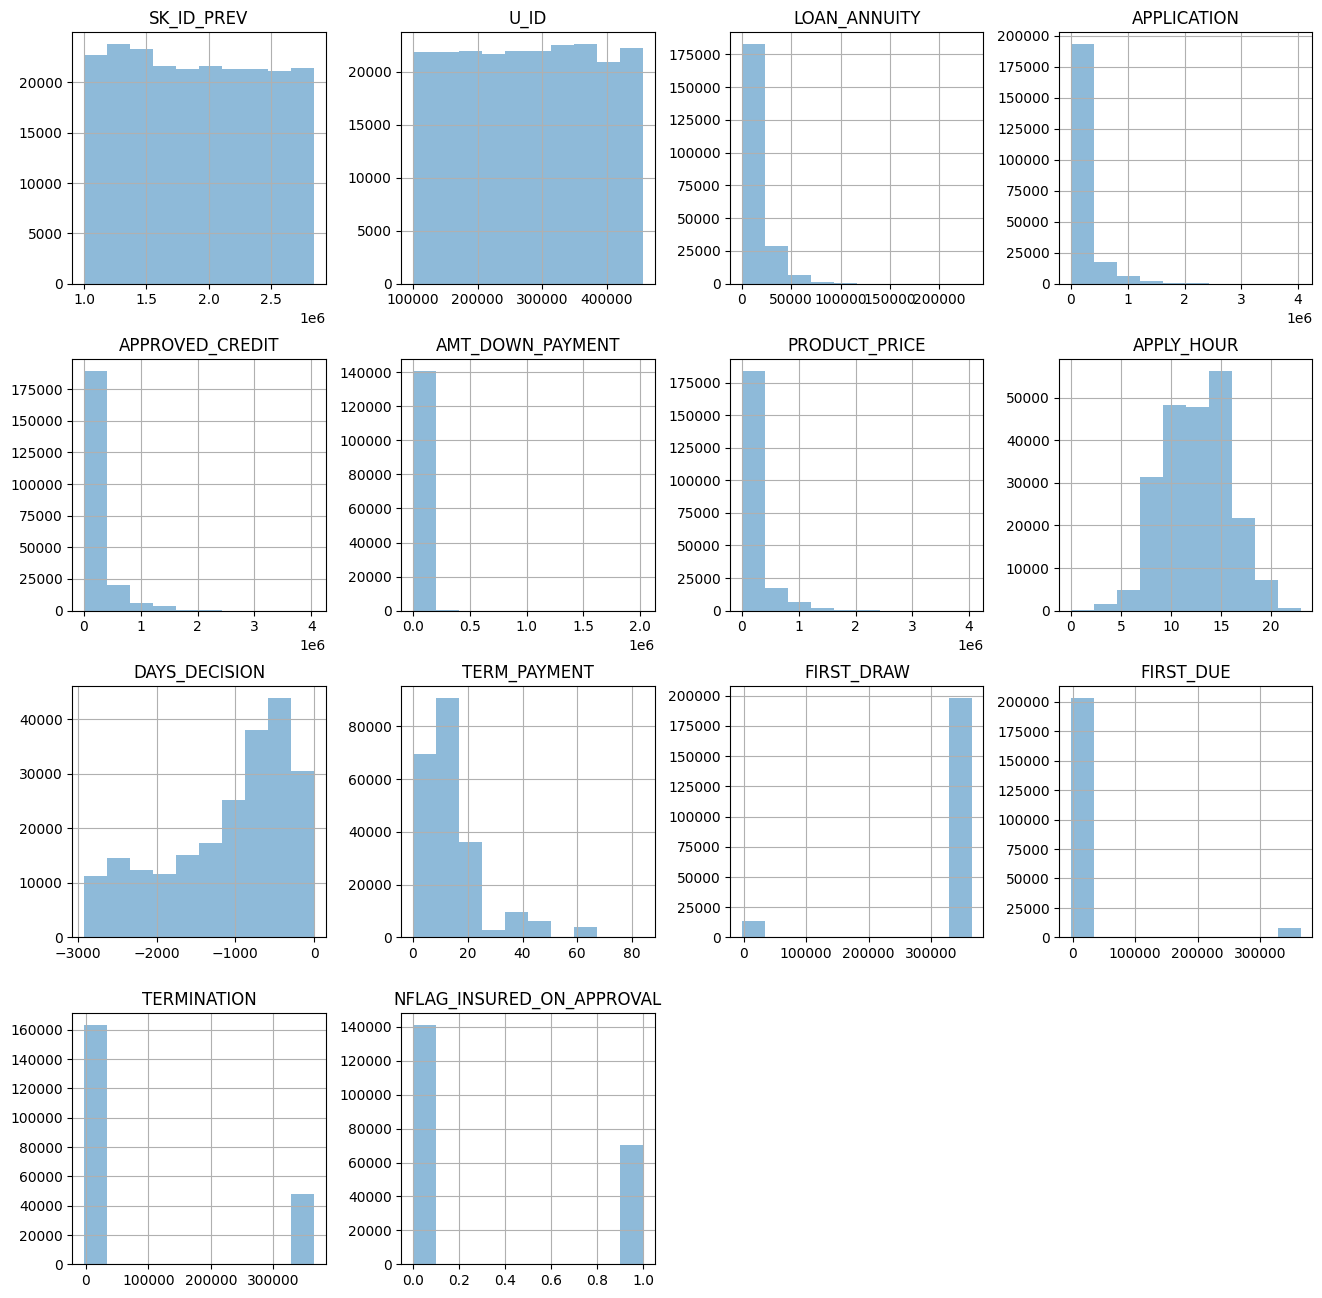

In [31]:
df_loan.hist(figsize=(16, 16), bins=10, alpha=0.5)

## **Feature engineering**

The variable NFLAG_INSURED_ON_APPROVAL have missing data of 4% compared to the whole data which is a significant amount. Since we consider this variable important, the column will be imputed with the most values.

In [32]:
mode_value = df_loan['NFLAG_INSURED_ON_APPROVAL'].mode()[0]
df_loan['NFLAG_INSURED_ON_APPROVAL'] = df_loan['NFLAG_INSURED_ON_APPROVAL'].fillna(mode_value)

<ipython-input-32-23b3bf3d33bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loan['NFLAG_INSURED_ON_APPROVAL'] = df_loan['NFLAG_INSURED_ON_APPROVAL'].fillna(mode_value)


In [33]:
df_loan.isna().sum()

SK_ID_PREV                       0
U_ID                             0
CONTRACT_TYPE                    0
LOAN_ANNUITY                     2
APPLICATION                      0
APPROVED_CREDIT                  0
AMT_DOWN_PAYMENT             78827
PRODUCT_PRICE                 9222
APPLY_DAYS                       0
APPLY_HOUR                       0
CONTRACT_STATUS                  0
DAYS_DECISION                    0
TERM_PAYMENT                     2
YIELD_GROUP                      0
FIRST_DRAW                    8280
FIRST_DUE                     8280
TERMINATION                   8280
NFLAG_INSURED_ON_APPROVAL        0
dtype: int64

In [34]:
df_loan

,SK_ID_PREV,U_ID,CONTRACT_TYPE,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_DAYS,APPLY_HOUR,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.00,17145.0,0.00,17145.00,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0
1,2819243,176158,Cash loans,47041.335,450000.00,470790.0,NaN,450000.00,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0
2,1383531,199383,Cash loans,23703.930,315000.00,340573.5,NaN,315000.00,SATURDAY,8,Approved,-684,18.0,low_normal,365243.0,-654.0,-137.0,1.0
4,1715995,447712,Cash loans,11368.620,270000.00,335754.0,NaN,270000.00,FRIDAY,7,Approved,-735,54.0,low_normal,365243.0,-705.0,-334.0,1.0
5,1151694,161591,Consumer loans,39111.075,214380.00,209497.5,13500.00,214380.00,FRIDAY,12,Approved,-989,6.0,middle,365243.0,-958.0,-804.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350691,2526478,451763,Cash loans,31170.645,720000.00,806485.5,NaN,720000.00,TUESDAY,10,Approved,-1071,42.0,low_normal,365243.0,-1041.0,-527.0,1.0
350692,1492303,348082,Cash loans,101793.555,990000.00,1018750.5,NaN,990000.00,WEDNESDAY,4,Approved,-568,12.0,middle,365243.0,-538.0,-200.0,1.0
350695,1229904,280109,Consumer loans,14490.360,140754.24,153013.5,3.24,140754.24,TUESDAY,14,Approved,-1301,12.0,low_normal,365243.0,-1270.0,-967.0,0.0
350697,1883185,418537,Cash loans,10751.985,90000.00,95940.0,0.00,90000.00,FRIDAY,10,Approved,-2199,12.0,high,365243.0,-2169.0,-1833.0,1.0


Next, a new variable will be created called credit ratio which is credit limit given by the company divided by credit requested by the applicant. A low ratio  might suggest that the applicant was granted a lower credit limit than requested.

Observations with empty values, or divition by 0 will be set as 1.

In [35]:
df_loan['credit_ratio'] = df_loan['APPROVED_CREDIT']/df_loan['PRODUCT_PRICE']

<ipython-input-35-ea7d829b96fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loan['credit_ratio'] = df_loan['APPROVED_CREDIT']/df_loan['PRODUCT_PRICE']


In [36]:
df_loan['credit_ratio'] = df_loan['credit_ratio'].replace(np.inf,1)
df_loan['credit_ratio'] = df_loan['credit_ratio'].fillna(1)

<ipython-input-36-d1f66696e0af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loan['credit_ratio'] = df_loan['credit_ratio'].replace(np.inf,1)
<ipython-input-36-d1f66696e0af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loan['credit_ratio'] = df_loan['credit_ratio'].fillna(1)


In [37]:
df_loan.describe()

,SK_ID_PREV,U_ID,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_HOUR,DAYS_DECISION,TERM_PAYMENT,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,credit_ratio
count,2.196870e+05,219687.000000,219685.000000,2.196870e+05,2.196870e+05,1.408600e+05,2.104650e+05,219687.000000,219687.000000,219685.000000,211407.000000,211407.000000,211407.000000,219687.000000,219687.000000
mean,1.904350e+06,278373.284286,14585.846247,1.794100e+05,2.014853e+05,6.832135e+03,1.872712e+05,12.602648,-1097.152235,14.171819,342238.632122,13228.355887,82378.742109,0.319468,1.020171
std,5.353069e+05,102659.397670,13626.136079,2.536923e+05,2.755490e+05,1.853554e+04,2.563351e+05,3.319055,792.382703,12.014098,88866.480608,71030.663471,153553.036032,0.466272,0.132606
min,1.000020e+06,100009.000000,0.000000,0.000000e+00,0.000000e+00,-4.500000e-01,0.000000e+00,0.000000,-2922.000000,0.000000,-2922.000000,-2892.000000,-2845.000000,0.000000,0.058824
25%,1.435808e+06,189444.000000,5883.345000,4.500000e+04,4.743450e+04,0.000000e+00,4.594050e+04,10.000000,-1638.000000,6.000000,365243.000000,-1625.000000,-1267.000000,0.000000,0.974218
50%,1.896829e+06,278740.000000,10277.775000,9.000000e+04,1.007640e+05,2.295000e+03,9.517950e+04,12.000000,-856.000000,12.000000,365243.000000,-825.000000,-495.000000,0.000000,1.000000
75%,2.369940e+06,367237.000000,18119.700000,1.914165e+05,2.250000e+05,8.280000e+03,2.025000e+05,15.000000,-454.000000,18.000000,365243.000000,-408.000000,-43.000000,1.000000,1.099000
max,2.843498e+06,456255.000000,233175.870000,4.050000e+06,4.050000e+06,2.025000e+06,4.050000e+06,23.000000,-2.000000,84.000000,365243.000000,365243.000000,365243.000000,1.000000,2.740852


<Axes: >

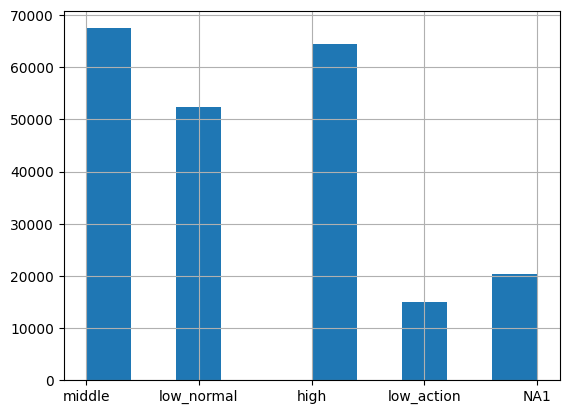

In [38]:
df_loan['YIELD_GROUP'].hist()

In [39]:
df_loan['YIELD_GROUP'] = df_loan['YIELD_GROUP'].replace('NA1', 'middle')

<ipython-input-39-083ade760070>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loan['YIELD_GROUP'] = df_loan['YIELD_GROUP'].replace('NA1', 'middle')


In [40]:
df_loan.isna().sum()

SK_ID_PREV                       0
U_ID                             0
CONTRACT_TYPE                    0
LOAN_ANNUITY                     2
APPLICATION                      0
APPROVED_CREDIT                  0
AMT_DOWN_PAYMENT             78827
PRODUCT_PRICE                 9222
APPLY_DAYS                       0
APPLY_HOUR                       0
CONTRACT_STATUS                  0
DAYS_DECISION                    0
TERM_PAYMENT                     2
YIELD_GROUP                      0
FIRST_DRAW                    8280
FIRST_DUE                     8280
TERMINATION                   8280
NFLAG_INSURED_ON_APPROVAL        0
credit_ratio                     0
dtype: int64

In [41]:
df_loan[['SK_ID_PREV','credit_ratio','NFLAG_INSURED_ON_APPROVAL','YIELD_GROUP']]

,SK_ID_PREV,credit_ratio,NFLAG_INSURED_ON_APPROVAL,YIELD_GROUP
0,2030495,1.000000,0.0,middle
1,2819243,1.046200,1.0,middle
2,1383531,1.081186,1.0,low_normal
4,1715995,1.243533,1.0,low_normal
5,1151694,0.977225,0.0,middle
...,...,...,...,...
350691,2526478,1.120119,1.0,low_normal
350692,1492303,1.029041,1.0,middle
350695,1229904,1.087097,0.0,low_normal
350697,1883185,1.066000,1.0,high


# **Customer segmentation with Weighted K-Means**

In [42]:
merged_df = pd.merge(df3, df_loan[['SK_ID_PREV','credit_ratio','NFLAG_INSURED_ON_APPROVAL','YIELD_GROUP']], on='SK_ID_PREV', how='left')

In [43]:
merged_df.isna().sum()

SK_ID_PREV                      0
U_ID                            0
num_inst                        0
unpaid_debt                     0
days_late                       0
credit_ratio                 8095
NFLAG_INSURED_ON_APPROVAL    8095
YIELD_GROUP                  8095
dtype: int64

In [44]:
merged_df = merged_df.dropna()

In [45]:
merged_df

,SK_ID_PREV,U_ID,num_inst,unpaid_debt,days_late,credit_ratio,NFLAG_INSURED_ON_APPROVAL,YIELD_GROUP
0,1000020,299072,12,0.0,0.0,1.088453,0.0,high
1,1000023,350748,4,0.0,0.0,1.000000,0.0,high
2,1000024,448518,12,0.0,0.0,0.988889,0.0,high
3,1000026,227096,4,0.0,0.0,1.052810,1.0,low_normal
4,1000027,277601,6,0.0,0.0,1.033000,1.0,middle
...,...,...,...,...,...,...,...,...
211706,2843484,229590,12,0.0,9.0,1.066000,1.0,middle
211707,2843489,387308,24,0.0,5.0,1.322688,0.0,low_normal
211708,2843490,294719,4,0.0,11.0,0.929499,1.0,high
211709,2843493,337804,30,0.0,4.0,1.000000,0.0,middle


In [46]:
merged_df.nunique()

SK_ID_PREV                   203616
U_ID                          71748
num_inst                        184
unpaid_debt                     646
days_late                       750
credit_ratio                  87260
NFLAG_INSURED_ON_APPROVAL         2
YIELD_GROUP                       4
dtype: int64

In [47]:
merged_df[merged_df['YIELD_GROUP'].isna()]

,SK_ID_PREV,U_ID,num_inst,unpaid_debt,days_late,credit_ratio,NFLAG_INSURED_ON_APPROVAL,YIELD_GROUP


In [48]:
merged_df[merged_df['U_ID']==393881]

,SK_ID_PREV,U_ID,num_inst,unpaid_debt,days_late,credit_ratio,NFLAG_INSURED_ON_APPROVAL,YIELD_GROUP
50571,1414356,393881,6,0.0,48.0,0.899271,0.0,high
66224,1544085,393881,7,0.0,0.0,1.000000,0.0,middle
83850,1692877,393881,6,0.0,0.0,1.000000,0.0,low_normal
85755,1717076,393881,3,0.0,0.0,1.000000,0.0,low_normal
86746,1723178,393881,18,0.0,1.0,1.000000,0.0,low_normal
152642,2309866,393881,22,0.0,0.0,1.000000,0.0,low_normal
156180,2342544,393881,10,0.0,0.0,1.082535,1.0,middle
157841,2357941,393881,7,0.0,0.0,1.000000,0.0,high
175650,2518909,393881,10,0.0,0.0,1.000000,0.0,high
211710,2843498,393881,6,0.0,0.0,1.000000,0.0,middle


In [49]:
merged_df['years_late'] = merged_df['days_late']/365
merged_df = merged_df[merged_df['years_late']<6]

In [50]:
merged_df['unpaid_debt'] = merged_df['unpaid_debt'].apply(lambda x: 1 if x > 0.1 else 0)

<ipython-input-50-c7f7bc0b58fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['unpaid_debt'] = merged_df['unpaid_debt'].apply(lambda x: 1 if x > 0.1 else 0)


In [51]:
merged_df.isna().sum()

SK_ID_PREV                   0
U_ID                         0
num_inst                     0
unpaid_debt                  0
days_late                    0
credit_ratio                 0
NFLAG_INSURED_ON_APPROVAL    0
YIELD_GROUP                  0
years_late                   0
dtype: int64

In [52]:
agg_result2 = merged_df.groupby(['U_ID']).agg({ #yg bagus sum sum min sama 3 variabel
    'unpaid_debt': 'max',
    'years_late': 'mean',
    'credit_ratio': 'min',
    'NFLAG_INSURED_ON_APPROVAL': lambda x: x.mode().iloc[0],  # Custom mode calculation
    'YIELD_GROUP': lambda x: x.mode().iloc[0] if not x.mode().empty else None  # Handling empty mode
}).reset_index()


In [53]:
agg_result = agg_result2.copy()

In [54]:
replace_dict = {'high': 4, 'middle': 3, 'low_normal': 2,'low_action':1}

# Replace values in the specified column
agg_result['YIELD_GROUP'] = agg_result['YIELD_GROUP'].replace(replace_dict)

In [55]:
agg_result['YIELD_GROUP'].unique()

array([3, 4, 2, 1])

In [56]:
agg_result.isna().sum()

U_ID                         0
unpaid_debt                  0
years_late                   0
credit_ratio                 0
NFLAG_INSURED_ON_APPROVAL    0
YIELD_GROUP                  0
dtype: int64

In [57]:
agg_result[agg_result['U_ID']==393881]

,U_ID,unpaid_debt,years_late,credit_ratio,NFLAG_INSURED_ON_APPROVAL,YIELD_GROUP
59323,393881,0,0.013425,0.899271,0.0,2


In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,QuantileTransformer,PowerTransformer
from sklearn import datasets

In [59]:
features = ['unpaid_debt','years_late','credit_ratio','YIELD_GROUP','NFLAG_INSURED_ON_APPROVAL']
X = agg_result[features]

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:,1] = X_scaled[:,1]*1.15
X_scaled[:,4] = X_scaled[:,4]*0.95 #0.9
X_scaled[:,2] = X_scaled[:,2]*0.85

In [62]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled[:,0] = X_scaled[:,0]*1.3
# X_scaled[:,1] = X_scaled[:,1]*1.3
# X_scaled[:,4] = X_scaled[:,4]*0.85 #0.9
# X_scaled[:,2] = X_scaled[:,2]*0.89

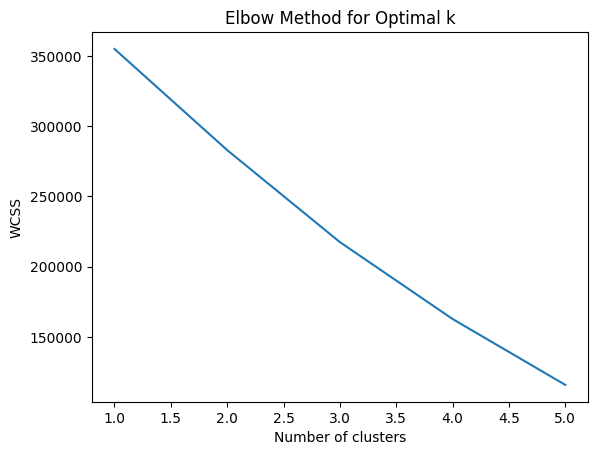

In [63]:
# Using the Elbow Method to find the optimal number of clusters (K)
wcss = []  # Within-Cluster Sum of Squares

for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()



In [64]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
agg_result['Cluster'] = kmeans.fit_predict(X_scaled)


<Axes: >

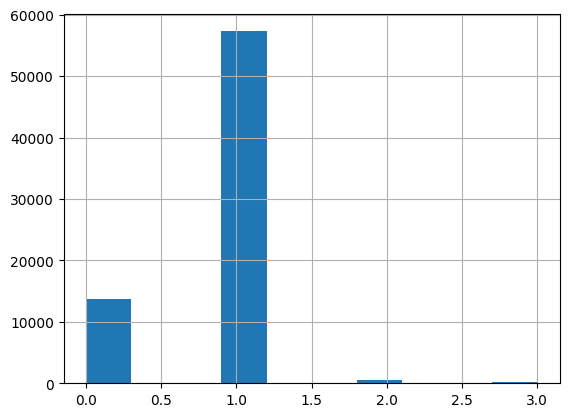

In [65]:
agg_result['Cluster'].hist()

In [66]:
import seaborn as sns

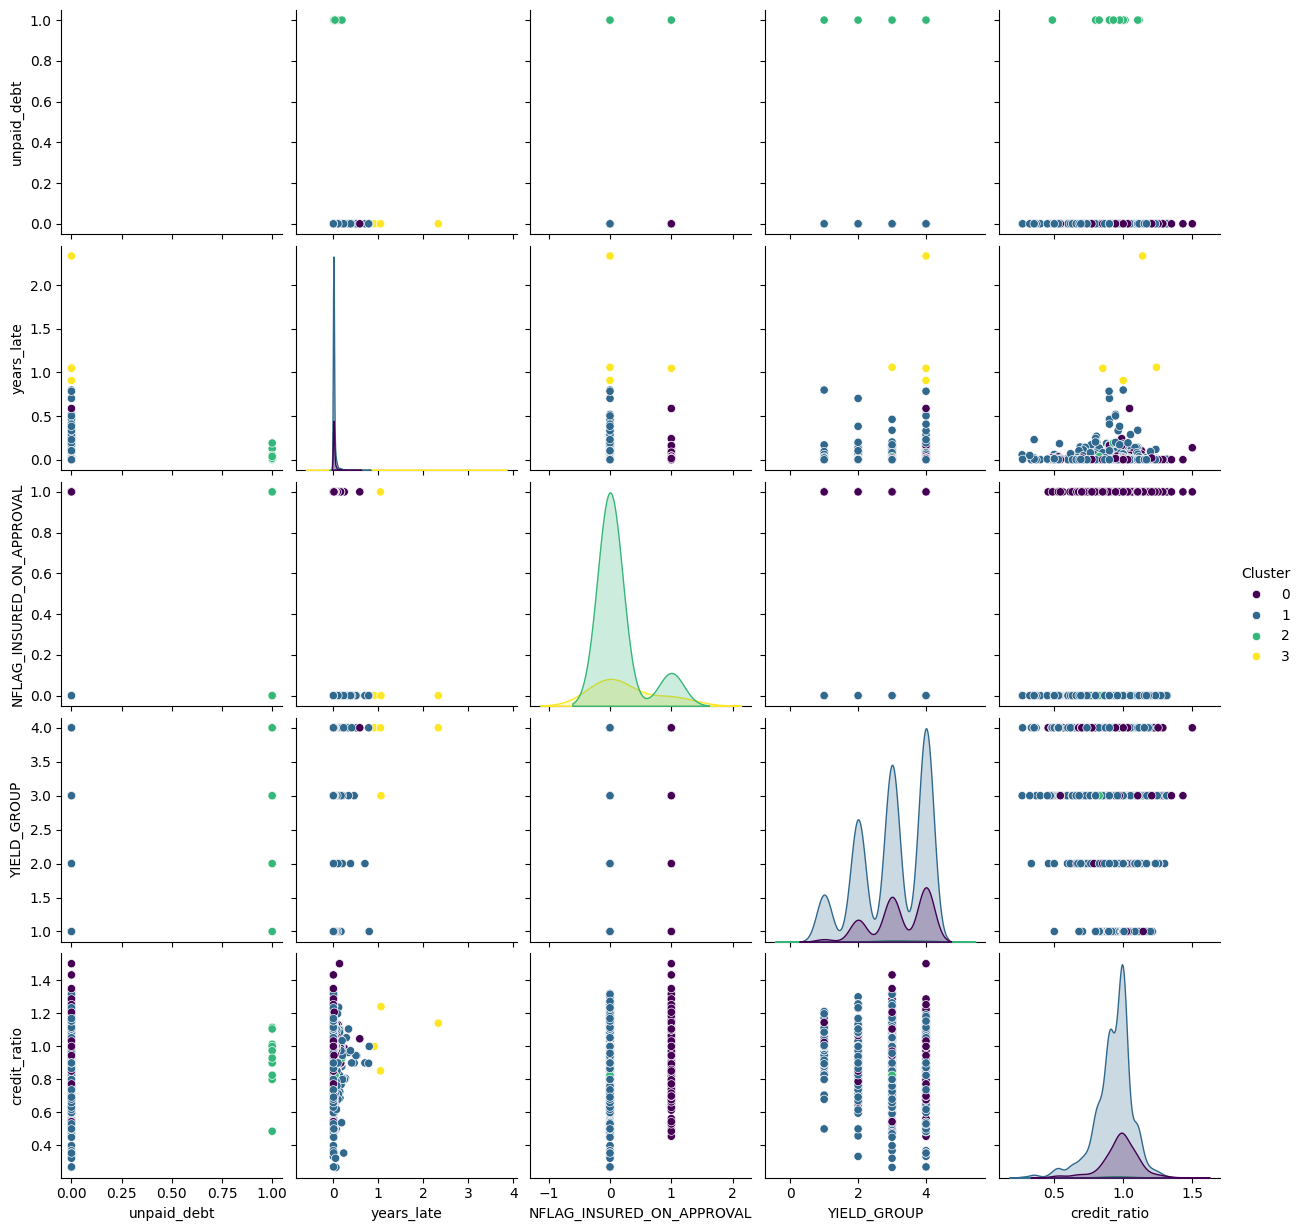

In [67]:
sns.pairplot(agg_result[['Cluster','unpaid_debt','years_late','NFLAG_INSURED_ON_APPROVAL','YIELD_GROUP','credit_ratio']].sample(2000), hue='Cluster', palette='viridis')


# **Training data cleaning, analysis, feature engineering, and processing.**

In [68]:
train = pd.read_csv("/content/drive/MyDrive/Dataset (CSV)/train.csv", sep =",")

In [69]:
train.shape

(61503, 23)

<ipython-input-70-d660d784a886>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)


<Axes: >

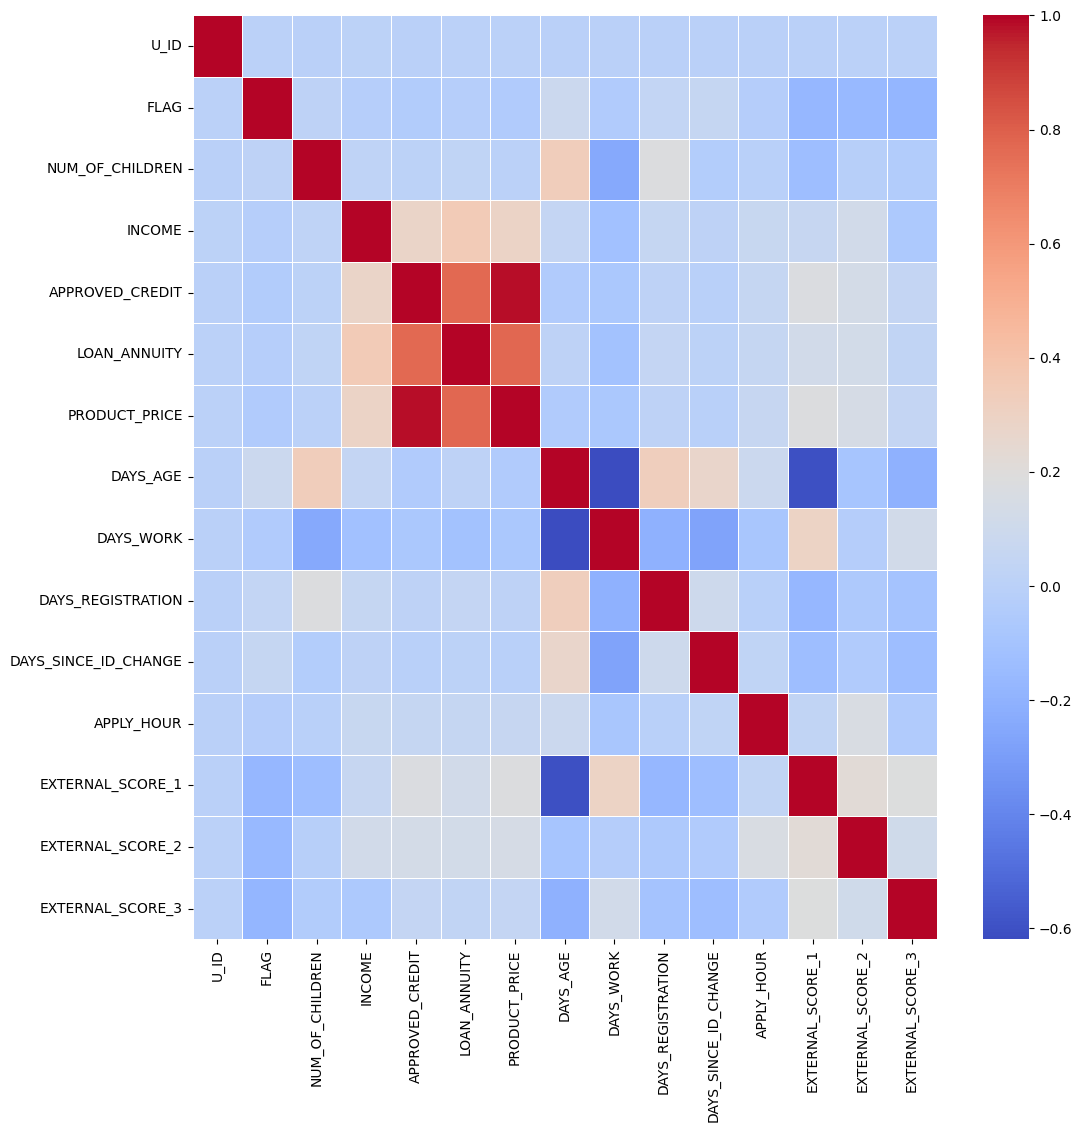

In [70]:
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.heatmap(train.corr(), annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)

In [71]:
train['credit_ratio'] = train['APPROVED_CREDIT']/train['PRODUCT_PRICE']
train['credit_ratio'] = train['credit_ratio'].replace(np.inf,1)
train['credit_ratio'] = train['credit_ratio'].fillna(1)

In [72]:
train = train.drop(columns=['EXTERNAL_SCORE_1', 'EXTERNAL_SCORE_2', 'EXTERNAL_SCORE_3'])
train = train.drop(columns=['APPROVED_CREDIT', 'PRODUCT_PRICE', 'LOAN_ANNUITY'])
train = train.drop(columns=['DAYS_REGISTRATION','APPLY_HOUR'])


* The variable Approved Credit, Loan_annuity, Product Price will be featured engineered as Credit Ratio.
* Days age and days work have high corelation. However, we think that each individual variable is important.

In [73]:
# Missing Data
total = train.isnull().sum().sort_values(ascending = False)
percentage = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percentage], axis = 1, keys = ['Total Missing Data', 'Percentage Missing Data'])
missing_data.head(7)

,Total Missing Data,Percentage Missing Data
U_ID,0,0.0
FLAG,0,0.0
CONTRACT_TYPE,0,0.0
GENDER,0,0.0
NUM_OF_CHILDREN,0,0.0
INCOME,0,0.0
INCOME_CATEGORY,0,0.0


In [74]:
numerical_features = train.select_dtypes(include=['number']).columns
categorical_features = train.select_dtypes(include=['object']).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 8
Categorical features : 8


In [75]:
# Since FLAG variable is basically an categorical variable (1 - client with late payment more than X days, 0 - all other cases), we decided to change it to 'object' using astype.
# Convert FLAG to object type in train_num
train_num['FLAG'] = train_num['FLAG'].astype('object')

# Move FLAG to train_cat DataFrame
train_cat['FLAG'] = train_num['FLAG']

# Drop FLAG from train_num DataFrame
train_num = train_num.drop('FLAG', axis=1)

<ipython-input-75-37ca490a3dff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num['FLAG'] = train_num['FLAG'].astype('object')
<ipython-input-75-37ca490a3dff>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat['FLAG'] = train_num['FLAG']


### Numerical

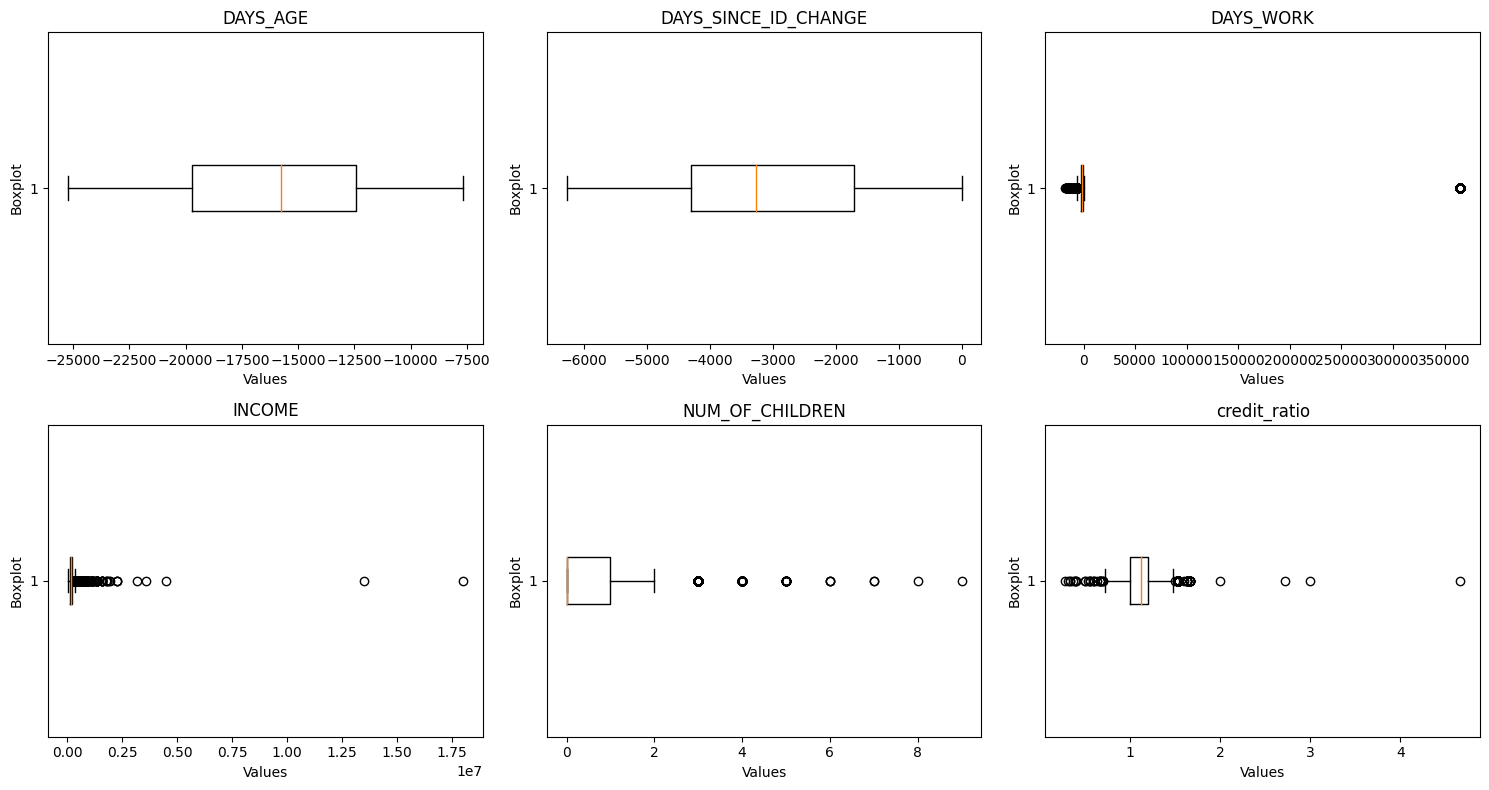

In [76]:
# U_ID is the column we want to exclude from boxplots
exclude_column = 'U_ID'

# Select only numerical columns (excluding U_ID)
numerical_columns = train_num.select_dtypes(include='number').columns.difference([exclude_column])

# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

# Plot boxplots for each numerical column
for i, column in enumerate(numerical_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].boxplot(train_num[column], vert=False)
    axes[row_idx, col_idx].set_title(column)
    axes[row_idx, col_idx].set_xlabel('Values')
    axes[row_idx, col_idx].set_ylabel('Boxplot')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

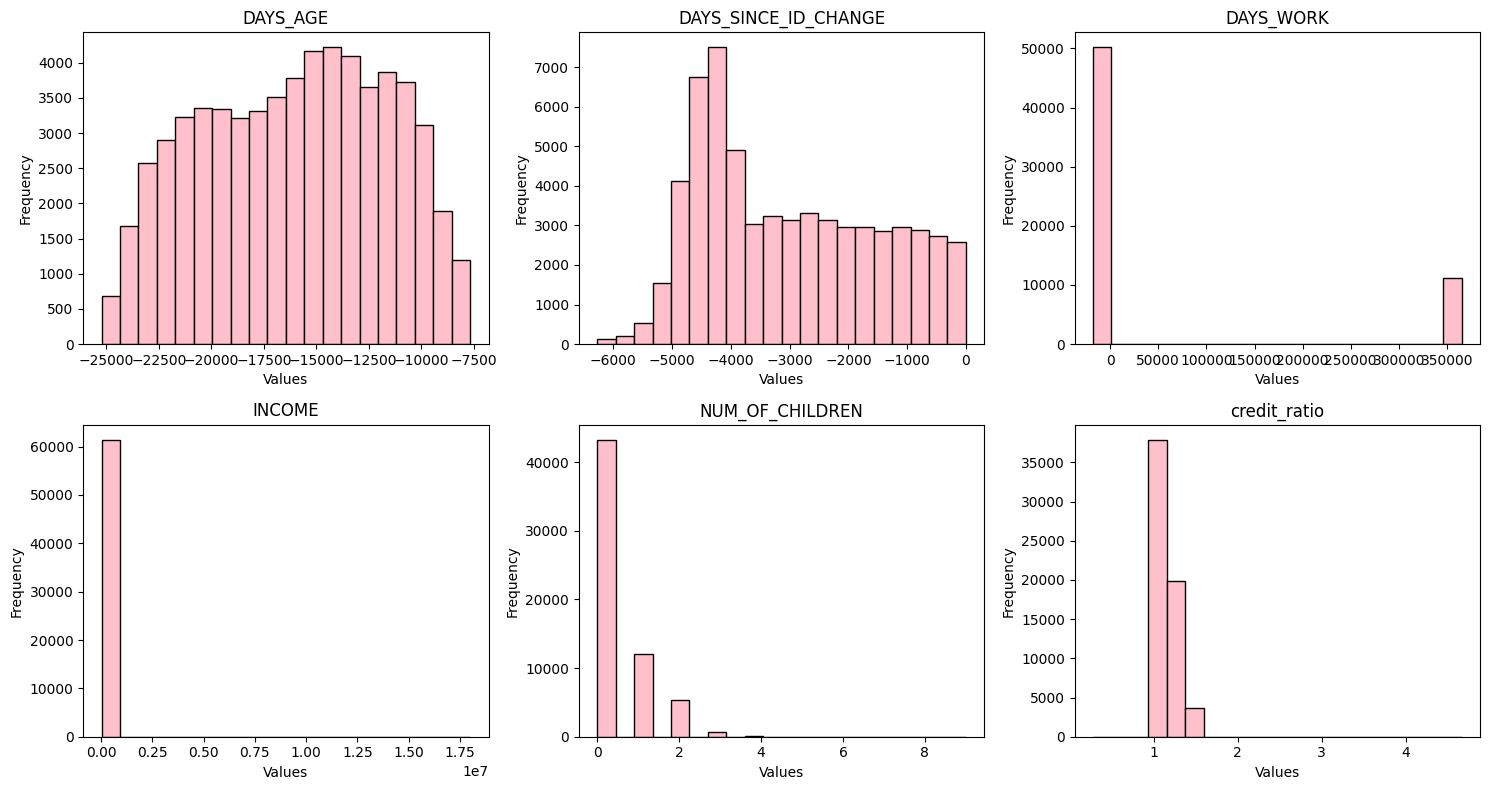

In [77]:
# U_ID is the column we want to exclude from histograms
exclude_column = 'U_ID'

# Select only numerical columns (excluding U_ID)
numerical_columns = train_num.select_dtypes(include='number').columns.difference([exclude_column])

# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

# Plot histograms for each numerical column
for i, column in enumerate(numerical_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].hist(train_num[column], bins=20, edgecolor='black', alpha=1, color='pink')
    axes[row_idx, col_idx].set_title(column)
    axes[row_idx, col_idx].set_xlabel('Values')
    axes[row_idx, col_idx].set_ylabel('Frequency')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

In [78]:
# Client's age in years at the time of application
train_num['YEARS_AGE'] = -train_num['DAYS_AGE'] / 365
# How many years before the application the person started current job
train_num['YEARS_WORK'] = -train_num['DAYS_WORK'] / 365
# How many years before the application did client change the identity document with which he applied for the loan
train_num['YEARS_SINCE_ID_CHANGE'] = -train_num['DAYS_SINCE_ID_CHANGE'] / 365
train_num = train_num.drop(columns=['DAYS_AGE', 'DAYS_WORK', 'DAYS_SINCE_ID_CHANGE'])

### Categorical

In [79]:
# ORGANIZATION CATEGORY has too many categories (58)
train_cat.drop(columns = 'ORGANIZATION_CATEGORY', inplace = True)
train_cat.drop(columns = 'APPLY_DAYS', inplace = True)

<ipython-input-79-d36bffce9c4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat.drop(columns = 'ORGANIZATION_CATEGORY', inplace = True)
<ipython-input-79-d36bffce9c4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat.drop(columns = 'APPLY_DAYS', inplace = True)


In [80]:
train_cat.nunique()

CONTRACT_TYPE       2
GENDER              2
INCOME_CATEGORY     7
EDUCATION           5
FAMILY_STATUS       5
HOUSING_CATEGORY    6
FLAG                2
dtype: int64

In [81]:
from sklearn.preprocessing import LabelEncoder
label_encode_columns = ['CONTRACT_TYPE', 'GENDER', 'FLAG']
one_hot_encode_columns = ['INCOME_CATEGORY', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_CATEGORY']

# Apply label encoding
label_encoder = LabelEncoder()

# GENDER(0: FEMALE, 1: MALE)
# CONTRACT_TYPE (1: Revolving loans, 0: Cash loans)
for column in label_encode_columns:
    train_cat[column] = label_encoder.fit_transform(train_cat[column])

# Apply one-hot encoding
train_cat_encoded = pd.get_dummies(train_cat, columns=one_hot_encode_columns, drop_first=True)

<ipython-input-81-53f9d45db1dd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat[column] = label_encoder.fit_transform(train_cat[column])
<ipython-input-81-53f9d45db1dd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat[column] = label_encoder.fit_transform(train_cat[column])
<ipython-input-81-53f9d45db1dd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [82]:
train = pd.concat([train_num, train_cat_encoded], axis=1)

In [83]:
outlier_threshold = 0

# Identify and count rows with outliers
outliers = train[train['YEARS_WORK'] < outlier_threshold]
num_outliers = outliers.shape[0]

print(f'Number of rows with outliers in YEARS_WORK: {num_outliers}')

# Remove rows with outliers
train = train[train['YEARS_WORK'] >= outlier_threshold]

Number of rows with outliers in YEARS_WORK: 11253


In [84]:
train = train[train['INCOME']<500000]

In [85]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Extract numerical columns
numerical_standardized = ['NUM_OF_CHILDREN', 'INCOME', 'YEARS_AGE', 'YEARS_WORK','YEARS_SINCE_ID_CHANGE']

# Standardize numerical columns
scaler = MinMaxScaler()

train[numerical_standardized] = scaler.fit_transform(train[numerical_standardized])

In [86]:
# Missing Data
total = train_num.isnull().sum().sort_values(ascending = False)
percentage = (train_num.isnull().sum()/train_num.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percentage], axis = 1, keys = ['Total Missing Data', 'Percentage Missing Data'])
missing_data.head(7)

,Total Missing Data,Percentage Missing Data
U_ID,0,0.0
NUM_OF_CHILDREN,0,0.0
INCOME,0,0.0
credit_ratio,0,0.0
YEARS_AGE,0,0.0
YEARS_WORK,0,0.0
YEARS_SINCE_ID_CHANGE,0,0.0


In [87]:
train.head()

,U_ID,NUM_OF_CHILDREN,INCOME,credit_ratio,YEARS_AGE,YEARS_WORK,YEARS_SINCE_ID_CHANGE,CONTRACT_TYPE,GENDER,FLAG,...,EDUCATION_Secondary / secondary special,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,HOUSING_CATEGORY_House / apartment,HOUSING_CATEGORY_Municipal apartment,HOUSING_CATEGORY_Office apartment,HOUSING_CATEGORY_Rented apartment,HOUSING_CATEGORY_With parents
0,333538,0.111111,0.086538,1.000000,0.220574,0.051259,0.439433,1,0,0,...,1,1,0,0,0,0,0,0,0,1
1,406644,0.111111,0.375000,1.118799,0.460432,0.250098,0.391297,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3,411997,0.000000,0.423077,1.198000,0.740914,0.583617,0.639146,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,241559,0.000000,0.230769,1.000000,0.076453,0.066280,0.262034,1,1,0,...,1,0,0,1,0,1,0,0,0,0
5,296530,0.222222,0.230769,1.316800,0.161009,0.041376,0.024227,0,0,0,...,0,1,0,0,0,1,0,0,0,0


# **Merge input variables with customer segmentation cluster**

In [91]:
agg_result

,U_ID,unpaid_debt,years_late,credit_ratio,NFLAG_INSURED_ON_APPROVAL,YIELD_GROUP,Cluster
0,100009,0,0.000000,0.839583,0.0,3,1
1,100039,0,0.000000,1.049371,1.0,4,0
2,100044,0,0.006164,0.947522,0.0,3,1
3,100045,0,0.006849,0.912612,0.0,4,1
4,100046,0,0.000000,1.208627,1.0,2,0
...,...,...,...,...,...,...,...
71735,456247,0,0.007534,0.936992,0.0,2,1
71736,456248,0,0.022831,1.049550,1.0,4,0
71737,456249,0,0.000000,1.066000,0.0,4,1
71738,456252,0,0.008219,0.986561,1.0,2,0


In [92]:
final_df = pd.merge(train, agg_result[['Cluster','U_ID']], on='U_ID', how='inner')

In [93]:
final_df

,U_ID,NUM_OF_CHILDREN,INCOME,credit_ratio,YEARS_AGE,YEARS_WORK,YEARS_SINCE_ID_CHANGE,CONTRACT_TYPE,GENDER,FLAG,...,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,HOUSING_CATEGORY_House / apartment,HOUSING_CATEGORY_Municipal apartment,HOUSING_CATEGORY_Office apartment,HOUSING_CATEGORY_Rented apartment,HOUSING_CATEGORY_With parents,Cluster
0,333538,0.111111,0.086538,1.000000,0.220574,0.051259,0.439433,1,0,0,...,1,0,0,0,0,0,0,0,1,1
1,406644,0.111111,0.375000,1.118799,0.460432,0.250098,0.391297,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,411997,0.000000,0.423077,1.198000,0.740914,0.583617,0.639146,0,1,0,...,1,0,0,0,1,0,0,0,0,0
3,241559,0.000000,0.230769,1.000000,0.076453,0.066280,0.262034,1,1,0,...,0,0,1,0,1,0,0,0,0,1
4,296530,0.222222,0.230769,1.316800,0.161009,0.041376,0.024227,0,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46809,395312,0.222222,0.278846,1.198000,0.275404,0.054107,0.615556,0,1,1,...,0,0,1,0,0,0,0,1,0,1
46810,312885,0.000000,0.326923,1.158397,0.696069,0.023899,0.418075,0,0,0,...,0,0,1,0,1,0,0,0,0,1
46811,131041,0.222222,0.067308,1.099000,0.301250,0.106818,0.529009,0,0,0,...,1,0,0,0,1,0,0,0,0,1
46812,251159,0.222222,0.711538,1.000000,0.376277,0.324418,0.431782,0,1,0,...,1,0,0,0,1,0,0,0,0,1


array([[<Axes: title={'center': 'Cluster'}>]], dtype=object)

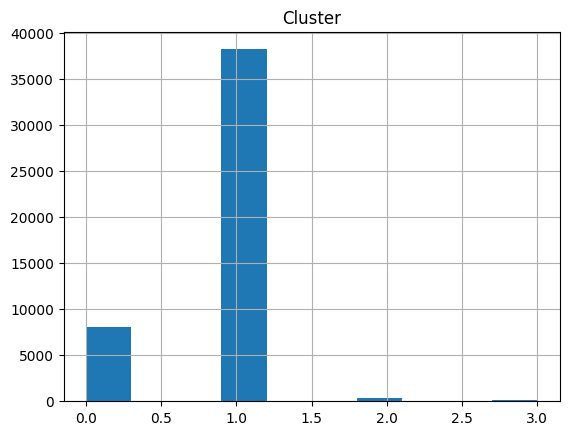

In [94]:
final_df[['Cluster']].hist()

In [95]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [96]:
final_df.columns

Index(['U_ID', 'NUM_OF_CHILDREN', 'INCOME', 'credit_ratio', 'YEARS_AGE',
       'YEARS_WORK', 'YEARS_SINCE_ID_CHANGE', 'CONTRACT_TYPE', 'GENDER',
       'FLAG', 'INCOME_CATEGORY_Commercial associate',
       'INCOME_CATEGORY_Pensioner', 'INCOME_CATEGORY_State servant',
       'INCOME_CATEGORY_Student', 'INCOME_CATEGORY_Unemployed',
       'INCOME_CATEGORY_Working', 'EDUCATION_Higher education',
       'EDUCATION_Incomplete higher', 'EDUCATION_Lower secondary',
       'EDUCATION_Secondary / secondary special', 'FAMILY_STATUS_Married',
       'FAMILY_STATUS_Separated', 'FAMILY_STATUS_Single / not married',
       'FAMILY_STATUS_Widow', 'HOUSING_CATEGORY_House / apartment',
       'HOUSING_CATEGORY_Municipal apartment',
       'HOUSING_CATEGORY_Office apartment',
       'HOUSING_CATEGORY_Rented apartment', 'HOUSING_CATEGORY_With parents',
       'Cluster'],
      dtype='object')

In [97]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Splitting the data into X (features) and y (target variable)
X = final_df.drop(['Cluster','U_ID'], axis=1) # Features
y = final_df['Cluster'] # Target variable

# Step 2: Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

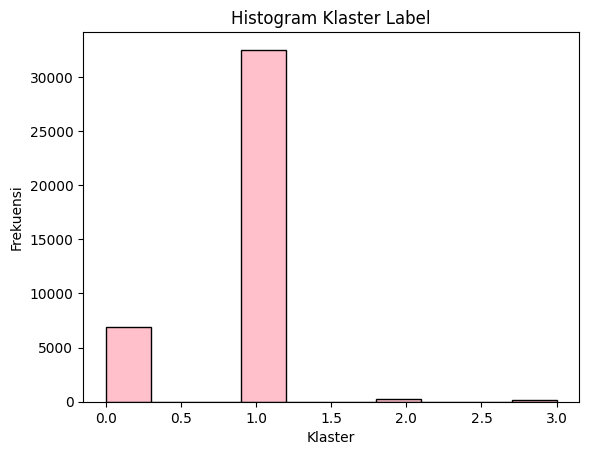

In [98]:
plt.hist(y_train, color='pink', edgecolor='black')
plt.title('Histogram Klaster Label')
plt.xlabel('Klaster')
plt.ylabel('Frekuensi')
plt.show()

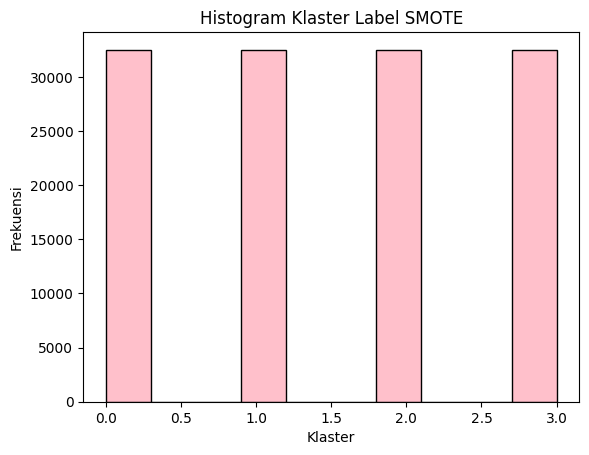

In [99]:
plt.hist(y_resampled, color='pink', edgecolor='black')
plt.title('Histogram Klaster Label SMOTE')
plt.xlabel('Klaster')
plt.ylabel('Frekuensi')
plt.show()

# **Modeling**

Accuracy on the test set: 0.7419906023067065

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.17      0.20      1213
           1       0.83      0.87      0.85      5738
           2       0.02      0.02      0.02        52
           3       0.00      0.00      0.00        20

    accuracy                           0.74      7023
   macro avg       0.27      0.27      0.27      7023
weighted avg       0.72      0.74      0.73      7023



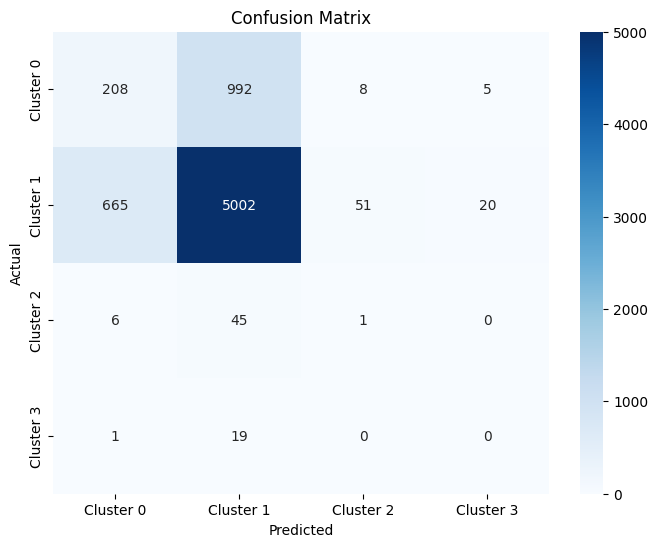

In [100]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Then train your model on the resampled data
rf_model.fit(X_resampled, y_resampled)

# Step 3: Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 4: Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'],
            yticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<ipython-input-101-bc9d46680be5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


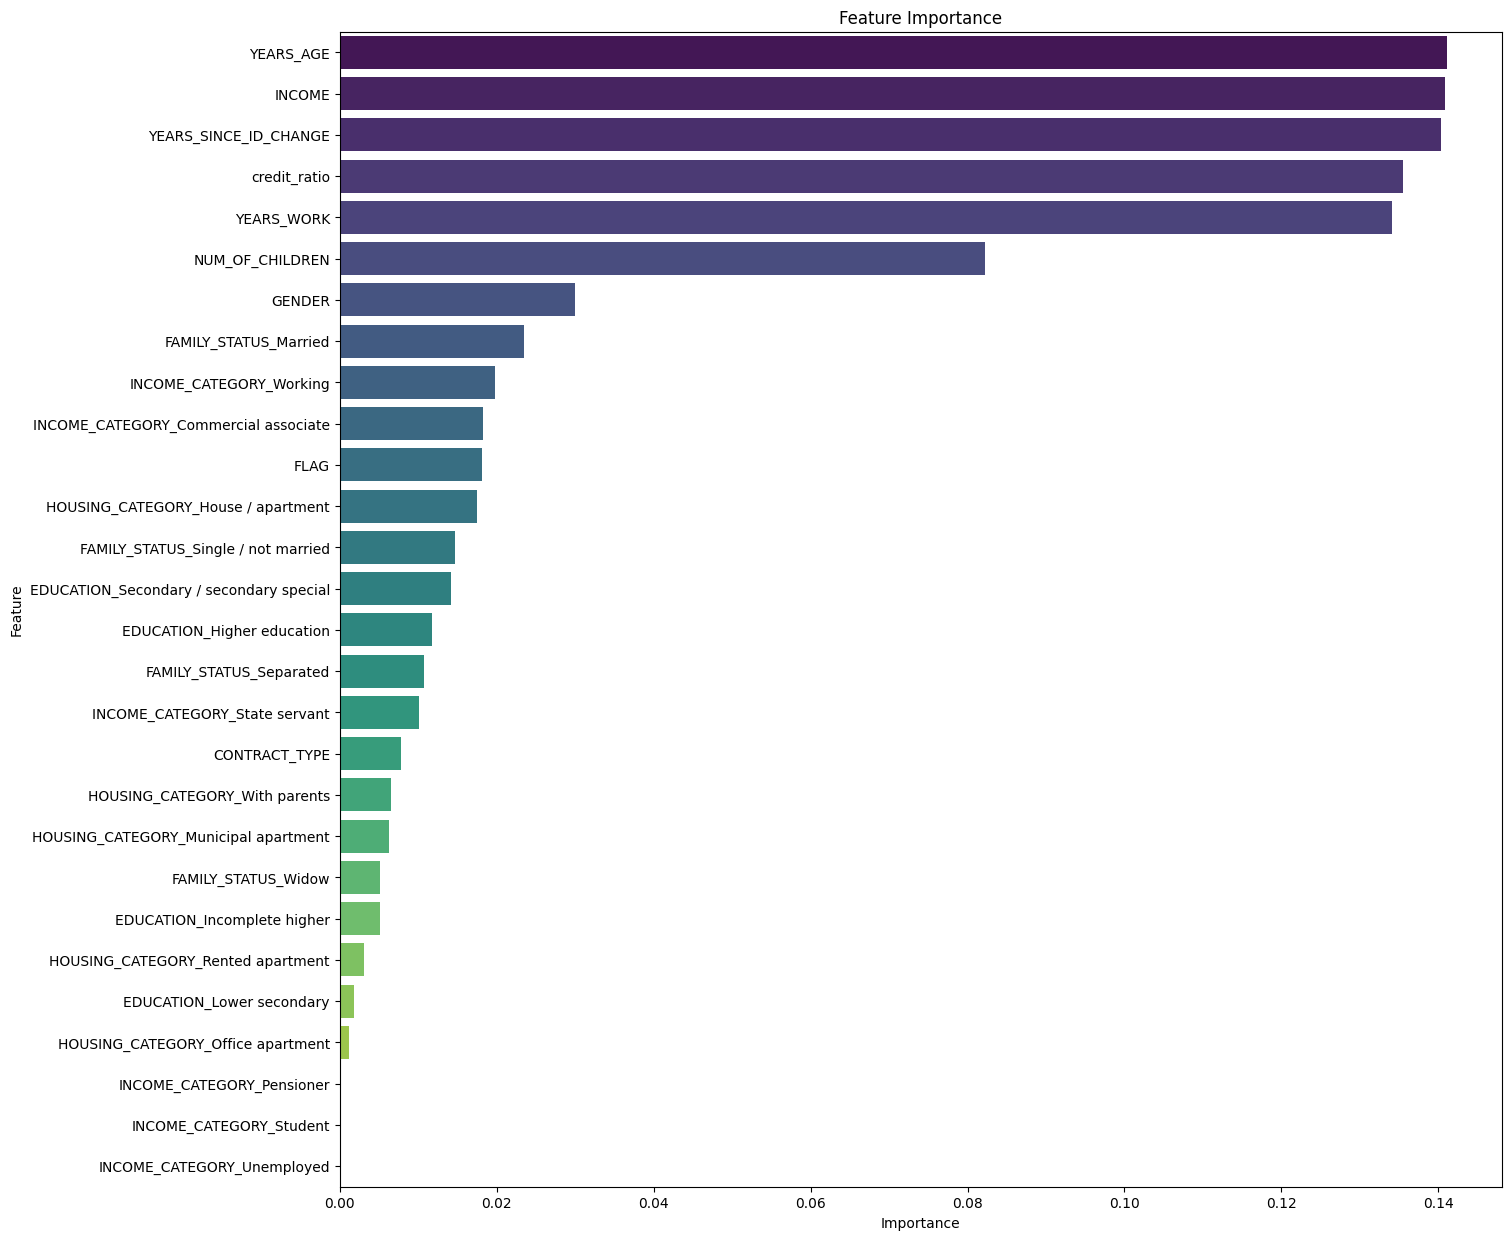

In [101]:
# Step 5: Display feature importance
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Creating a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 130040, number of used features: 25
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Accuracy on the test set: 0.7728890787412787

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.08      0.12      1213
           1       0.82      0.93      0.87      5738
           2       0.03      0.04      0.03        52
           3       0.00      0.00      0.00        20

    accuracy                           0.77      7023
   macro avg      

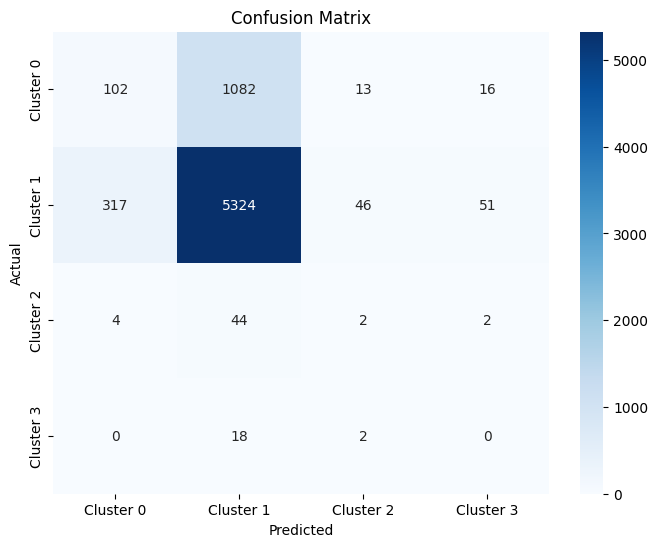

In [105]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
model = LGBMClassifier()
rf_model = LGBMClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_resampled, y_resampled)

# Step 3: Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 4: Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'],
            yticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy on the test set: 0.762637049693863

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.12      0.17      1213
           1       0.83      0.91      0.86      5738
           2       0.01      0.02      0.02        52
           3       0.00      0.00      0.00        20

    accuracy                           0.76      7023
   macro avg       0.27      0.26      0.26      7023
weighted avg       0.72      0.76      0.74      7023



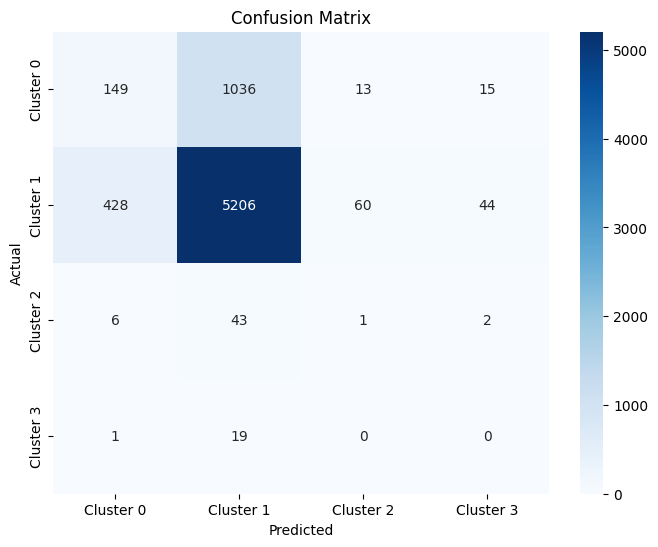

In [107]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

rf_model = XGBClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_resampled, y_resampled)

# Step 3: Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 4: Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'],
            yticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Epoch 1/5
995/995 [==============================] - 4s 3ms/step - loss: 0.5409 - accuracy: 0.8115 - val_loss: 0.5091 - val_accuracy: 0.8205
Epoch 2/5
995/995 [==============================] - 2s 2ms/step - loss: 0.5131 - accuracy: 0.8162 - val_loss: 0.5074 - val_accuracy: 0.8205
Epoch 3/5
995/995 [==============================] - 3s 3ms/step - loss: 0.5120 - accuracy: 0.8162 - val_loss: 0.5071 - val_accuracy: 0.8205
Epoch 4/5
995/995 [==============================] - 4s 4ms/step - loss: 0.5109 - accuracy: 0.8162 - val_loss: 0.5073 - val_accuracy: 0.8205
Epoch 5/5
220/220 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.817029759362096

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1213
           1       0.82      1.00      0.90      5738
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        20

    accuracy                  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


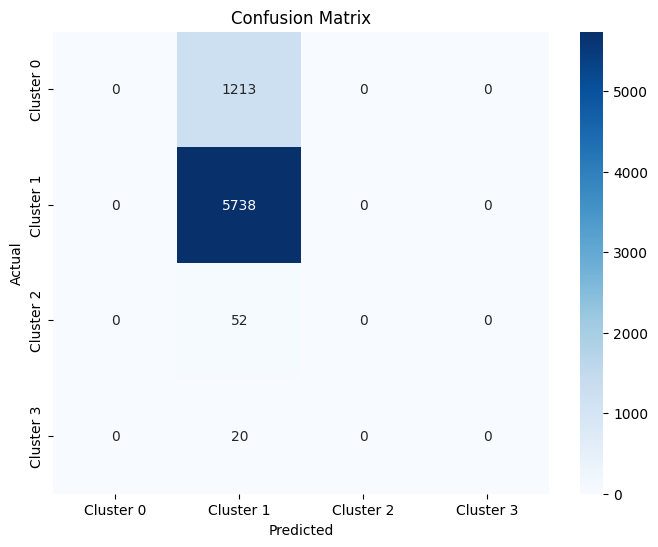

In [108]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 3 output neurons for 3 classes, softmax for multi-class classification

# Step 3: Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Step 5: Evaluate the model on the test set
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class labels

# Step 6: Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'],
            yticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy on the test set (Decision Tree): 0.6275096112772319

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.20      0.30      0.24      1213
           1       0.83      0.70      0.76      5738
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        20

    accuracy                           0.63      7023
   macro avg       0.26      0.25      0.25      7023
weighted avg       0.71      0.63      0.66      7023



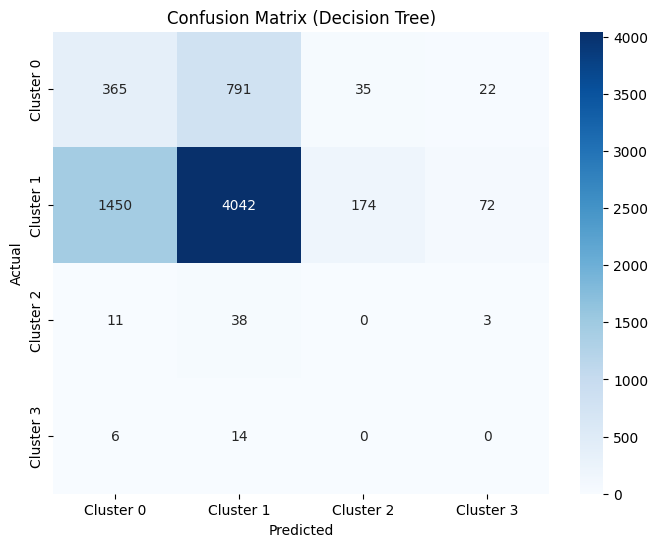

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Instantiate the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Step 2: Train the model on the resampled data
dt_model.fit(X_resampled, y_resampled)

# Step 3: Making predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Step 4: Evaluating the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy on the test set (Decision Tree):", accuracy_dt)

class_report_dt = classification_report(y_test, y_pred_dt)
print("\nClassification Report (Decision Tree):\n", class_report_dt)

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plotting the Confusion Matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'],
            yticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy on the test set (Logistic Regression): 0.41478000854335756

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.24      0.32      0.27      1213
           1       0.87      0.44      0.58      5738
           2       0.01      0.23      0.02        52
           3       0.01      0.35      0.01        20

    accuracy                           0.41      7023
   macro avg       0.28      0.33      0.22      7023
weighted avg       0.75      0.41      0.52      7023



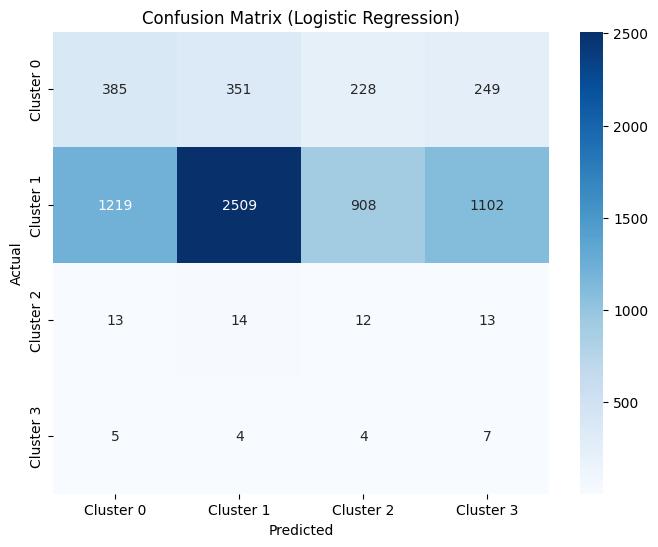

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Instantiate the Logistic Regression model
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

# Step 2: Train the model on the resampled data
logreg_model.fit(X_resampled, y_resampled)

# Step 3: Making predictions on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Step 4: Evaluating the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Accuracy on the test set (Logistic Regression):", accuracy_logreg)

class_report_logreg = classification_report(y_test, y_pred_logreg)
print("\nClassification Report (Logistic Regression):\n", class_report_logreg)

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plotting the Confusion Matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'],
            yticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy on the test set (AdaBoost): 0.5178698561868148

Classification Report (AdaBoost):
               precision    recall  f1-score   support

           0       0.20      0.31      0.24      1213
           1       0.85      0.57      0.68      5738
           2       0.01      0.10      0.01        52
           3       0.00      0.15      0.01        20

    accuracy                           0.52      7023
   macro avg       0.27      0.28      0.24      7023
weighted avg       0.73      0.52      0.60      7023



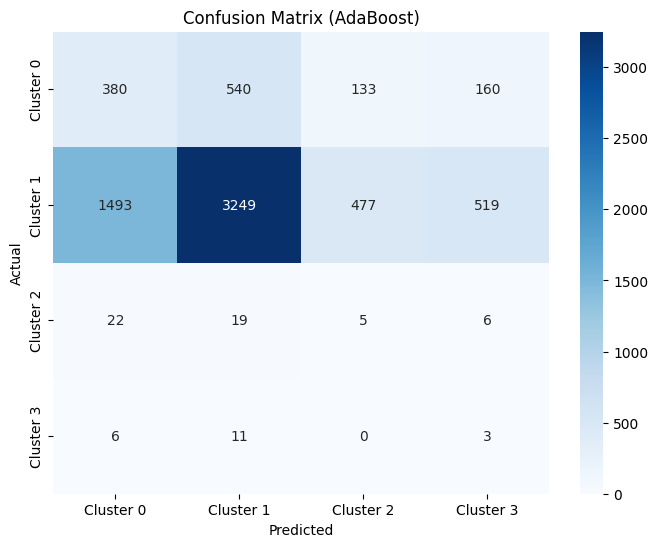

In [111]:
from sklearn.ensemble import AdaBoostClassifier

# Instantiate AdaBoost model
ada_model = AdaBoostClassifier()

# Train the model on the resampled data
ada_model.fit(X_resampled, y_resampled)

# Making predictions on the test set
y_pred_ada = ada_model.predict(X_test)

# Evaluating the model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print("Accuracy on the test set (AdaBoost):", accuracy_ada)

class_report_ada = classification_report(y_test, y_pred_ada)
print("\nClassification Report (AdaBoost):\n", class_report_ada)

# Confusion Matrix for AdaBoost
cm_ada = confusion_matrix(y_test, y_pred_ada)

# Plotting the Confusion Matrix for AdaBoost
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'],
            yticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
plt.title('Confusion Matrix (AdaBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
